In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 23:56:33.546176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 23:56:33.546206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-07 23:56:38.804585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 23:56:38.804614: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 23:56:38.804634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 23:56:38.804954: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 2s 16ms/step - loss: 0.7046 - accuracy: 0.5031 - auc: 0.5006 - val_loss: 0.6943 - val_accuracy: 0.5042 - val_auc: 0.5116
Epoch 2/394
39/39 [==============================] - 0s 8ms/step - loss: 0.7028 - accuracy: 0.5079 - auc: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.5129 - val_auc: 0.5185
Epoch 3/394
39/39 [==============================] - 0s 8ms/step - loss: 0.7006 - accuracy: 0.5087 - auc: 0.5094 - val_loss: 0.6918 - val_accuracy: 0.5214 - val_auc: 0.5266
Epoch 4/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6994 - accuracy: 0.5088 - auc: 0.5141 - val_loss: 0.6907 - val_accuracy: 0.5268 - val_auc: 0.5343
Epoch 5/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.5228 - auc: 0.5189 - val_loss: 0.6896 - val_accuracy: 0.5322 - val_auc: 0.5424
Epoch 6/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6971 - accuracy: 0.5166 - auc: 0.5229 - val_loss: 0.6885 - val_accuracy

39/39 [==============================] - 0s 9ms/step - loss: 0.6422 - accuracy: 0.6385 - auc: 0.6971 - val_loss: 0.6180 - val_accuracy: 0.7571 - val_auc: 0.8506
Epoch 49/394
39/39 [==============================] - 1s 14ms/step - loss: 0.6397 - accuracy: 0.6390 - auc: 0.7002 - val_loss: 0.6147 - val_accuracy: 0.7605 - val_auc: 0.8543
Epoch 50/394
39/39 [==============================] - 0s 13ms/step - loss: 0.6371 - accuracy: 0.6466 - auc: 0.7073 - val_loss: 0.6114 - val_accuracy: 0.7642 - val_auc: 0.8581
Epoch 51/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6325 - accuracy: 0.6537 - auc: 0.7177 - val_loss: 0.6079 - val_accuracy: 0.7669 - val_auc: 0.8619
Epoch 52/394
39/39 [==============================] - 1s 13ms/step - loss: 0.6356 - accuracy: 0.6447 - auc: 0.7026 - val_loss: 0.6045 - val_accuracy: 0.7706 - val_auc: 0.8653
Epoch 53/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6320 - accuracy: 0.6478 - auc: 0.7125 - val_loss: 0.6010 - val

Epoch 95/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5000 - accuracy: 0.7553 - auc: 0.8442 - val_loss: 0.4144 - val_accuracy: 0.8776 - val_auc: 0.9542
Epoch 96/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5062 - accuracy: 0.7463 - auc: 0.8357 - val_loss: 0.4105 - val_accuracy: 0.8795 - val_auc: 0.9553
Epoch 97/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4922 - accuracy: 0.7598 - auc: 0.8497 - val_loss: 0.4063 - val_accuracy: 0.8814 - val_auc: 0.9563
Epoch 98/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4978 - accuracy: 0.7473 - auc: 0.8422 - val_loss: 0.4024 - val_accuracy: 0.8834 - val_auc: 0.9572
Epoch 99/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4922 - accuracy: 0.7558 - auc: 0.8468 - val_loss: 0.3986 - val_accuracy: 0.8843 - val_auc: 0.9581
Epoch 100/394
39/39 [==============================] - 0s 11ms/step - loss: 0.4902 - accuracy: 0.7612 - auc: 0.8491 - val_loss: 0.

Epoch 142/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4059 - accuracy: 0.8148 - auc: 0.8985 - val_loss: 0.2809 - val_accuracy: 0.9229 - val_auc: 0.9795
Epoch 143/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3970 - accuracy: 0.8146 - auc: 0.9026 - val_loss: 0.2791 - val_accuracy: 0.9237 - val_auc: 0.9798
Epoch 144/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4004 - accuracy: 0.8148 - auc: 0.9010 - val_loss: 0.2774 - val_accuracy: 0.9244 - val_auc: 0.9800
Epoch 145/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3967 - accuracy: 0.8157 - auc: 0.9031 - val_loss: 0.2758 - val_accuracy: 0.9247 - val_auc: 0.9802
Epoch 146/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3972 - accuracy: 0.8148 - auc: 0.9027 - val_loss: 0.2741 - val_accuracy: 0.9252 - val_auc: 0.9804
Epoch 147/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3966 - accuracy: 0.8178 - auc: 0.9029 - val_los

Epoch 189/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3473 - accuracy: 0.8454 - auc: 0.9265 - val_loss: 0.2252 - val_accuracy: 0.9409 - val_auc: 0.9857
Epoch 190/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3531 - accuracy: 0.8425 - auc: 0.9242 - val_loss: 0.2246 - val_accuracy: 0.9408 - val_auc: 0.9858
Epoch 191/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3543 - accuracy: 0.8439 - auc: 0.9235 - val_loss: 0.2239 - val_accuracy: 0.9413 - val_auc: 0.9858
Epoch 192/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3449 - accuracy: 0.8441 - auc: 0.9281 - val_loss: 0.2232 - val_accuracy: 0.9414 - val_auc: 0.9859
Epoch 193/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3490 - accuracy: 0.8495 - auc: 0.9264 - val_loss: 0.2224 - val_accuracy: 0.9418 - val_auc: 0.9860
Epoch 194/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3456 - accuracy: 0.8471 - auc: 0.9277 - val_loss

Epoch 236/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3202 - accuracy: 0.8617 - auc: 0.9385 - val_loss: 0.1973 - val_accuracy: 0.9491 - val_auc: 0.9882
Epoch 237/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3139 - accuracy: 0.8677 - auc: 0.9411 - val_loss: 0.1968 - val_accuracy: 0.9492 - val_auc: 0.9882
Epoch 238/394
39/39 [==============================] - 1s 14ms/step - loss: 0.3139 - accuracy: 0.8658 - auc: 0.9409 - val_loss: 0.1964 - val_accuracy: 0.9493 - val_auc: 0.9882
Epoch 239/394
39/39 [==============================] - 0s 10ms/step - loss: 0.3087 - accuracy: 0.8667 - auc: 0.9428 - val_loss: 0.1958 - val_accuracy: 0.9491 - val_auc: 0.9883
Epoch 240/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3219 - accuracy: 0.8636 - auc: 0.9384 - val_loss: 0.1955 - val_accuracy: 0.9492 - val_auc: 0.9883
Epoch 241/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3217 - accuracy: 0.8656 - auc: 0.9377 - val_l

Epoch 283/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.8802 - auc: 0.9489 - val_loss: 0.1801 - val_accuracy: 0.9546 - val_auc: 0.9895
Epoch 284/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2899 - accuracy: 0.8793 - auc: 0.9496 - val_loss: 0.1796 - val_accuracy: 0.9549 - val_auc: 0.9895
Epoch 285/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2974 - accuracy: 0.8744 - auc: 0.9469 - val_loss: 0.1796 - val_accuracy: 0.9545 - val_auc: 0.9895
Epoch 286/394
39/39 [==============================] - 0s 9ms/step - loss: 0.2919 - accuracy: 0.8773 - auc: 0.9493 - val_loss: 0.1791 - val_accuracy: 0.9550 - val_auc: 0.9895
Epoch 287/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2899 - accuracy: 0.8759 - auc: 0.9498 - val_loss: 0.1786 - val_accuracy: 0.9558 - val_auc: 0.9896
Epoch 288/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2888 - accuracy: 0.8808 - auc: 0.9504 - val_los

Epoch 330/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2730 - accuracy: 0.8919 - auc: 0.9562 - val_loss: 0.1667 - val_accuracy: 0.9589 - val_auc: 0.9904
Epoch 331/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2731 - accuracy: 0.8852 - auc: 0.9554 - val_loss: 0.1666 - val_accuracy: 0.9589 - val_auc: 0.9904
Epoch 332/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2650 - accuracy: 0.8926 - auc: 0.9586 - val_loss: 0.1662 - val_accuracy: 0.9589 - val_auc: 0.9904
Epoch 333/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2675 - accuracy: 0.8900 - auc: 0.9573 - val_loss: 0.1659 - val_accuracy: 0.9589 - val_auc: 0.9905
Epoch 334/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.8867 - auc: 0.9551 - val_loss: 0.1657 - val_accuracy: 0.9593 - val_auc: 0.9905
Epoch 335/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2772 - accuracy: 0.8837 - auc: 0.9543 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2496 - accuracy: 0.9012 - auc: 0.9634 - val_loss: 0.1563 - val_accuracy: 0.9618 - val_auc: 0.9911
Epoch 378/394
39/39 [==============================] - 0s 10ms/step - loss: 0.2618 - accuracy: 0.8937 - auc: 0.9592 - val_loss: 0.1562 - val_accuracy: 0.9618 - val_auc: 0.9911
Epoch 379/394
39/39 [==============================] - 1s 14ms/step - loss: 0.2503 - accuracy: 0.9017 - auc: 0.9633 - val_loss: 0.1561 - val_accuracy: 0.9620 - val_auc: 0.9911
Epoch 380/394
39/39 [==============================] - 0s 9ms/step - loss: 0.2583 - accuracy: 0.8952 - auc: 0.9603 - val_loss: 0.1559 - val_accuracy: 0.9619 - val_auc: 0.9911
Epoch 381/394
39/39 [==============================] - 1s 15ms/step - loss: 0.2565 - accuracy: 0.8986 - auc: 0.9607 - val_loss: 0.1558 - val_accuracy: 0.9617 - val_auc: 0.9911
Epoch 382/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2483 - accuracy: 0.9024 - auc: 0.9634 - val_l

39/39 [==============================] - 0s 8ms/step - loss: 0.6242 - accuracy: 0.6526 - auc: 0.7186 - val_loss: 0.5932 - val_accuracy: 0.7491 - val_auc: 0.8408
Epoch 29/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6188 - accuracy: 0.6608 - auc: 0.7294 - val_loss: 0.5876 - val_accuracy: 0.7541 - val_auc: 0.8462
Epoch 30/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6107 - accuracy: 0.6749 - auc: 0.7448 - val_loss: 0.5814 - val_accuracy: 0.7582 - val_auc: 0.8516
Epoch 31/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6085 - accuracy: 0.6738 - auc: 0.7461 - val_loss: 0.5753 - val_accuracy: 0.7638 - val_auc: 0.8569
Epoch 32/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6062 - accuracy: 0.6751 - auc: 0.7450 - val_loss: 0.5691 - val_accuracy: 0.7688 - val_auc: 0.8621
Epoch 33/394
39/39 [==============================] - 1s 13ms/step - loss: 0.5971 - accuracy: 0.6795 - auc: 0.7575 - val_loss: 0.5628 - val_a

39/39 [==============================] - 0s 8ms/step - loss: 0.4371 - accuracy: 0.7917 - auc: 0.8811 - val_loss: 0.3304 - val_accuracy: 0.9026 - val_auc: 0.9700
Epoch 76/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4299 - accuracy: 0.8010 - auc: 0.8858 - val_loss: 0.3269 - val_accuracy: 0.9043 - val_auc: 0.9707
Epoch 77/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4293 - accuracy: 0.7981 - auc: 0.8863 - val_loss: 0.3235 - val_accuracy: 0.9051 - val_auc: 0.9714
Epoch 78/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4254 - accuracy: 0.8005 - auc: 0.8879 - val_loss: 0.3201 - val_accuracy: 0.9072 - val_auc: 0.9722
Epoch 79/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4193 - accuracy: 0.8017 - auc: 0.8918 - val_loss: 0.3167 - val_accuracy: 0.9090 - val_auc: 0.9729
Epoch 80/394
39/39 [==============================] - 0s 10ms/step - loss: 0.4267 - accuracy: 0.7960 - auc: 0.8864 - val_loss: 0.3136 - val_a

Epoch 122/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3544 - accuracy: 0.8410 - auc: 0.9231 - val_loss: 0.2325 - val_accuracy: 0.9416 - val_auc: 0.9856
Epoch 123/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3425 - accuracy: 0.8473 - auc: 0.9297 - val_loss: 0.2311 - val_accuracy: 0.9420 - val_auc: 0.9857
Epoch 124/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3574 - accuracy: 0.8377 - auc: 0.9224 - val_loss: 0.2301 - val_accuracy: 0.9420 - val_auc: 0.9858
Epoch 125/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3470 - accuracy: 0.8475 - auc: 0.9272 - val_loss: 0.2291 - val_accuracy: 0.9424 - val_auc: 0.9859
Epoch 126/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3391 - accuracy: 0.8538 - auc: 0.9308 - val_loss: 0.2278 - val_accuracy: 0.9428 - val_auc: 0.9860
Epoch 127/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3461 - accuracy: 0.8511 - auc: 0.9281 - val_loss

Epoch 169/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3175 - accuracy: 0.8610 - auc: 0.9392 - val_loss: 0.1956 - val_accuracy: 0.9516 - val_auc: 0.9889
Epoch 170/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3103 - accuracy: 0.8654 - auc: 0.9418 - val_loss: 0.1951 - val_accuracy: 0.9518 - val_auc: 0.9889
Epoch 171/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3039 - accuracy: 0.8725 - auc: 0.9448 - val_loss: 0.1945 - val_accuracy: 0.9517 - val_auc: 0.9890
Epoch 172/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3106 - accuracy: 0.8721 - auc: 0.9426 - val_loss: 0.1939 - val_accuracy: 0.9521 - val_auc: 0.9890
Epoch 173/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3176 - accuracy: 0.8648 - auc: 0.9397 - val_loss: 0.1937 - val_accuracy: 0.9521 - val_auc: 0.9890
Epoch 174/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3056 - accuracy: 0.8725 - auc: 0.9447 - val_loss

Epoch 216/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2858 - accuracy: 0.8807 - auc: 0.9513 - val_loss: 0.1761 - val_accuracy: 0.9570 - val_auc: 0.9903
Epoch 217/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2748 - accuracy: 0.8905 - auc: 0.9556 - val_loss: 0.1757 - val_accuracy: 0.9568 - val_auc: 0.9903
Epoch 218/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2777 - accuracy: 0.8823 - auc: 0.9535 - val_loss: 0.1751 - val_accuracy: 0.9571 - val_auc: 0.9903
Epoch 219/394
39/39 [==============================] - 0s 11ms/step - loss: 0.2804 - accuracy: 0.8858 - auc: 0.9536 - val_loss: 0.1746 - val_accuracy: 0.9574 - val_auc: 0.9904
Epoch 220/394
39/39 [==============================] - 1s 14ms/step - loss: 0.2800 - accuracy: 0.8820 - auc: 0.9533 - val_loss: 0.1743 - val_accuracy: 0.9572 - val_auc: 0.9904
Epoch 221/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2797 - accuracy: 0.8853 - auc: 0.9532 - val_

Epoch 263/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2586 - accuracy: 0.8974 - auc: 0.9604 - val_loss: 0.1625 - val_accuracy: 0.9607 - val_auc: 0.9911
Epoch 264/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2598 - accuracy: 0.8991 - auc: 0.9601 - val_loss: 0.1621 - val_accuracy: 0.9607 - val_auc: 0.9911
Epoch 265/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2526 - accuracy: 0.8998 - auc: 0.9624 - val_loss: 0.1618 - val_accuracy: 0.9607 - val_auc: 0.9912
Epoch 266/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2683 - accuracy: 0.8912 - auc: 0.9571 - val_loss: 0.1616 - val_accuracy: 0.9609 - val_auc: 0.9912
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2678 - accuracy: 0.8946 - auc: 0.9572 - val_loss: 0.1614 - val_accuracy: 0.9609 - val_auc: 0.9912
Epoch 268/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2655 - accuracy: 0.8933 - auc: 0.9580 - val_los

Epoch 310/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2504 - accuracy: 0.9048 - auc: 0.9629 - val_loss: 0.1515 - val_accuracy: 0.9639 - val_auc: 0.9916
Epoch 311/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2392 - accuracy: 0.9061 - auc: 0.9662 - val_loss: 0.1512 - val_accuracy: 0.9641 - val_auc: 0.9917
Epoch 312/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2475 - accuracy: 0.9028 - auc: 0.9635 - val_loss: 0.1510 - val_accuracy: 0.9643 - val_auc: 0.9916
Epoch 313/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2495 - accuracy: 0.9033 - auc: 0.9630 - val_loss: 0.1509 - val_accuracy: 0.9639 - val_auc: 0.9917
Epoch 314/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2527 - accuracy: 0.9010 - auc: 0.9620 - val_loss: 0.1509 - val_accuracy: 0.9645 - val_auc: 0.9917
Epoch 315/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2355 - accuracy: 0.9078 - auc: 0.9673 - val_lo

Epoch 357/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2333 - accuracy: 0.9084 - auc: 0.9675 - val_loss: 0.1428 - val_accuracy: 0.9669 - val_auc: 0.9921
Epoch 358/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2233 - accuracy: 0.9143 - auc: 0.9707 - val_loss: 0.1426 - val_accuracy: 0.9671 - val_auc: 0.9921
Epoch 359/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2292 - accuracy: 0.9097 - auc: 0.9686 - val_loss: 0.1423 - val_accuracy: 0.9671 - val_auc: 0.9921
Epoch 360/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2349 - accuracy: 0.9080 - auc: 0.9669 - val_loss: 0.1423 - val_accuracy: 0.9667 - val_auc: 0.9921
Epoch 361/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2211 - accuracy: 0.9119 - auc: 0.9708 - val_loss: 0.1421 - val_accuracy: 0.9668 - val_auc: 0.9921
Epoch 362/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2204 - accuracy: 0.9149 - auc: 0.9710 - val_lo

39/39 [==============================] - 0s 8ms/step - loss: 0.6502 - accuracy: 0.6133 - auc: 0.6705 - val_loss: 0.6275 - val_accuracy: 0.7189 - val_auc: 0.8104
Epoch 9/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6428 - accuracy: 0.6307 - auc: 0.6897 - val_loss: 0.6191 - val_accuracy: 0.7325 - val_auc: 0.8241
Epoch 10/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.6276 - auc: 0.6894 - val_loss: 0.6109 - val_accuracy: 0.7436 - val_auc: 0.8373
Epoch 11/394
39/39 [==============================] - 0s 11ms/step - loss: 0.6296 - accuracy: 0.6463 - auc: 0.7118 - val_loss: 0.6021 - val_accuracy: 0.7543 - val_auc: 0.8487
Epoch 12/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6212 - accuracy: 0.6612 - auc: 0.7296 - val_loss: 0.5928 - val_accuracy: 0.7640 - val_auc: 0.8592
Epoch 13/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6153 - accuracy: 0.6647 - auc: 0.7351 - val_loss: 0.5832 - val_acc

39/39 [==============================] - 0s 8ms/step - loss: 0.3964 - accuracy: 0.8177 - auc: 0.9045 - val_loss: 0.2830 - val_accuracy: 0.9245 - val_auc: 0.9798
Epoch 56/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3988 - accuracy: 0.8168 - auc: 0.9024 - val_loss: 0.2798 - val_accuracy: 0.9258 - val_auc: 0.9802
Epoch 57/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3936 - accuracy: 0.8170 - auc: 0.9049 - val_loss: 0.2770 - val_accuracy: 0.9265 - val_auc: 0.9805
Epoch 58/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3853 - accuracy: 0.8225 - auc: 0.9094 - val_loss: 0.2740 - val_accuracy: 0.9275 - val_auc: 0.9809
Epoch 59/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3856 - accuracy: 0.8230 - auc: 0.9086 - val_loss: 0.2711 - val_accuracy: 0.9279 - val_auc: 0.9812
Epoch 60/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3958 - accuracy: 0.8156 - auc: 0.9033 - val_loss: 0.2687 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.3206 - accuracy: 0.8615 - auc: 0.9379 - val_loss: 0.2036 - val_accuracy: 0.9468 - val_auc: 0.9878
Epoch 103/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3099 - accuracy: 0.8694 - auc: 0.9433 - val_loss: 0.2025 - val_accuracy: 0.9470 - val_auc: 0.9879
Epoch 104/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3186 - accuracy: 0.8644 - auc: 0.9392 - val_loss: 0.2018 - val_accuracy: 0.9470 - val_auc: 0.9879
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3085 - accuracy: 0.8633 - auc: 0.9432 - val_loss: 0.2008 - val_accuracy: 0.9474 - val_auc: 0.9879
Epoch 106/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3143 - accuracy: 0.8675 - auc: 0.9409 - val_loss: 0.1997 - val_accuracy: 0.9481 - val_auc: 0.9880
Epoch 107/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3128 - accuracy: 0.8688 - auc: 0.9418 - val_loss: 0.1988 - val

Epoch 149/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2819 - accuracy: 0.8854 - auc: 0.9533 - val_loss: 0.1738 - val_accuracy: 0.9559 - val_auc: 0.9898
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2795 - accuracy: 0.8851 - auc: 0.9537 - val_loss: 0.1732 - val_accuracy: 0.9563 - val_auc: 0.9899
Epoch 151/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2836 - accuracy: 0.8817 - auc: 0.9515 - val_loss: 0.1729 - val_accuracy: 0.9554 - val_auc: 0.9899
Epoch 152/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2811 - accuracy: 0.8855 - auc: 0.9529 - val_loss: 0.1723 - val_accuracy: 0.9556 - val_auc: 0.9900
Epoch 153/394
39/39 [==============================] - 0s 13ms/step - loss: 0.2855 - accuracy: 0.8837 - auc: 0.9516 - val_loss: 0.1722 - val_accuracy: 0.9563 - val_auc: 0.9900
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2708 - accuracy: 0.8904 - auc: 0.9564 - val_los

Epoch 196/394
39/39 [==============================] - 0s 10ms/step - loss: 0.2504 - accuracy: 0.8989 - auc: 0.9627 - val_loss: 0.1560 - val_accuracy: 0.9606 - val_auc: 0.9910
Epoch 197/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2562 - accuracy: 0.9015 - auc: 0.9616 - val_loss: 0.1556 - val_accuracy: 0.9607 - val_auc: 0.9911
Epoch 198/394
39/39 [==============================] - 0s 10ms/step - loss: 0.2516 - accuracy: 0.8993 - auc: 0.9623 - val_loss: 0.1554 - val_accuracy: 0.9609 - val_auc: 0.9911
Epoch 199/394
39/39 [==============================] - 1s 14ms/step - loss: 0.2452 - accuracy: 0.9012 - auc: 0.9643 - val_loss: 0.1549 - val_accuracy: 0.9609 - val_auc: 0.9911
Epoch 200/394
39/39 [==============================] - 1s 15ms/step - loss: 0.2498 - accuracy: 0.9037 - auc: 0.9629 - val_loss: 0.1547 - val_accuracy: 0.9607 - val_auc: 0.9911
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2543 - accuracy: 0.9000 - auc: 0.9618 - val_

Epoch 243/394
39/39 [==============================] - 0s 11ms/step - loss: 0.2181 - accuracy: 0.9184 - auc: 0.9719 - val_loss: 0.1420 - val_accuracy: 0.9647 - val_auc: 0.9919
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2256 - accuracy: 0.9095 - auc: 0.9699 - val_loss: 0.1417 - val_accuracy: 0.9645 - val_auc: 0.9919
Epoch 245/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2229 - accuracy: 0.9141 - auc: 0.9705 - val_loss: 0.1415 - val_accuracy: 0.9645 - val_auc: 0.9919
Epoch 246/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2258 - accuracy: 0.9108 - auc: 0.9696 - val_loss: 0.1416 - val_accuracy: 0.9644 - val_auc: 0.9918
Epoch 247/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2260 - accuracy: 0.9142 - auc: 0.9700 - val_loss: 0.1414 - val_accuracy: 0.9649 - val_auc: 0.9919
Epoch 248/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2210 - accuracy: 0.9127 - auc: 0.9709 - val_

Epoch 290/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2043 - accuracy: 0.9226 - auc: 0.9750 - val_loss: 0.1305 - val_accuracy: 0.9685 - val_auc: 0.9924
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2109 - accuracy: 0.9210 - auc: 0.9735 - val_loss: 0.1306 - val_accuracy: 0.9677 - val_auc: 0.9925
Epoch 292/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2014 - accuracy: 0.9266 - auc: 0.9760 - val_loss: 0.1303 - val_accuracy: 0.9678 - val_auc: 0.9925
Epoch 293/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2077 - accuracy: 0.9213 - auc: 0.9740 - val_loss: 0.1302 - val_accuracy: 0.9680 - val_auc: 0.9924
Epoch 294/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2004 - accuracy: 0.9216 - auc: 0.9760 - val_loss: 0.1299 - val_accuracy: 0.9682 - val_auc: 0.9925
Epoch 295/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2049 - accuracy: 0.9235 - auc: 0.9748 - val_los

Epoch 337/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1903 - accuracy: 0.9321 - auc: 0.9781 - val_loss: 0.1207 - val_accuracy: 0.9708 - val_auc: 0.9929
Epoch 338/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1915 - accuracy: 0.9292 - auc: 0.9778 - val_loss: 0.1207 - val_accuracy: 0.9708 - val_auc: 0.9928
Epoch 339/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1822 - accuracy: 0.9321 - auc: 0.9802 - val_loss: 0.1204 - val_accuracy: 0.9706 - val_auc: 0.9929
Epoch 340/394
39/39 [==============================] - 0s 11ms/step - loss: 0.1894 - accuracy: 0.9305 - auc: 0.9783 - val_loss: 0.1202 - val_accuracy: 0.9706 - val_auc: 0.9929
Epoch 341/394
39/39 [==============================] - 0s 12ms/step - loss: 0.1918 - accuracy: 0.9308 - auc: 0.9777 - val_loss: 0.1202 - val_accuracy: 0.9706 - val_auc: 0.9928
Epoch 342/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.9308 - auc: 0.9794 - val_l

Epoch 384/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1690 - accuracy: 0.9384 - auc: 0.9827 - val_loss: 0.1129 - val_accuracy: 0.9724 - val_auc: 0.9931
Epoch 385/394
39/39 [==============================] - 0s 8ms/step - loss: 0.1689 - accuracy: 0.9381 - auc: 0.9830 - val_loss: 0.1128 - val_accuracy: 0.9726 - val_auc: 0.9931
Epoch 386/394
39/39 [==============================] - 1s 14ms/step - loss: 0.1690 - accuracy: 0.9404 - auc: 0.9828 - val_loss: 0.1125 - val_accuracy: 0.9724 - val_auc: 0.9931
Epoch 387/394
39/39 [==============================] - 0s 9ms/step - loss: 0.1735 - accuracy: 0.9375 - auc: 0.9814 - val_loss: 0.1124 - val_accuracy: 0.9724 - val_auc: 0.9931
Epoch 388/394
39/39 [==============================] - 0s 10ms/step - loss: 0.1691 - accuracy: 0.9413 - auc: 0.9827 - val_loss: 0.1123 - val_accuracy: 0.9725 - val_auc: 0.9931
Epoch 389/394
39/39 [==============================] - 0s 7ms/step - loss: 0.1710 - accuracy: 0.9389 - auc: 0.9820 - val_lo

39/39 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.5676 - auc: 0.5902 - val_loss: 0.6728 - val_accuracy: 0.6227 - val_auc: 0.6756
Epoch 36/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6809 - accuracy: 0.5628 - auc: 0.5885 - val_loss: 0.6721 - val_accuracy: 0.6257 - val_auc: 0.6798
Epoch 37/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6814 - accuracy: 0.5571 - auc: 0.5844 - val_loss: 0.6714 - val_accuracy: 0.6283 - val_auc: 0.6840
Epoch 38/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6776 - accuracy: 0.5757 - auc: 0.5998 - val_loss: 0.6707 - val_accuracy: 0.6314 - val_auc: 0.6882
Epoch 39/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6782 - accuracy: 0.5705 - auc: 0.5992 - val_loss: 0.6700 - val_accuracy: 0.6342 - val_auc: 0.6926
Epoch 40/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6777 - accuracy: 0.5712 - auc: 0.6008 - val_loss: 0.6693 - val_a

39/39 [==============================] - 0s 7ms/step - loss: 0.6323 - accuracy: 0.6519 - auc: 0.7123 - val_loss: 0.6134 - val_accuracy: 0.7435 - val_auc: 0.8369
Epoch 83/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6372 - accuracy: 0.6434 - auc: 0.6982 - val_loss: 0.6112 - val_accuracy: 0.7472 - val_auc: 0.8398
Epoch 84/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6348 - accuracy: 0.6443 - auc: 0.7043 - val_loss: 0.6089 - val_accuracy: 0.7494 - val_auc: 0.8428
Epoch 85/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6319 - accuracy: 0.6457 - auc: 0.7078 - val_loss: 0.6065 - val_accuracy: 0.7519 - val_auc: 0.8458
Epoch 86/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6294 - accuracy: 0.6538 - auc: 0.7135 - val_loss: 0.6040 - val_accuracy: 0.7542 - val_auc: 0.8488
Epoch 87/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6288 - accuracy: 0.6502 - auc: 0.7132 - val_loss: 0.6015 - val_accu

Epoch 129/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5210 - accuracy: 0.7416 - auc: 0.8260 - val_loss: 0.4421 - val_accuracy: 0.8728 - val_auc: 0.9525
Epoch 130/828
39/39 [==============================] - 0s 10ms/step - loss: 0.5141 - accuracy: 0.7445 - auc: 0.8331 - val_loss: 0.4373 - val_accuracy: 0.8749 - val_auc: 0.9540
Epoch 131/828
39/39 [==============================] - 0s 10ms/step - loss: 0.5164 - accuracy: 0.7497 - auc: 0.8307 - val_loss: 0.4330 - val_accuracy: 0.8777 - val_auc: 0.9554
Epoch 132/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5114 - accuracy: 0.7492 - auc: 0.8339 - val_loss: 0.4286 - val_accuracy: 0.8789 - val_auc: 0.9566
Epoch 133/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5109 - accuracy: 0.7479 - auc: 0.8337 - val_loss: 0.4244 - val_accuracy: 0.8812 - val_auc: 0.9578
Epoch 134/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4995 - accuracy: 0.7578 - auc: 0.8440 - val_

Epoch 176/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4137 - accuracy: 0.8129 - auc: 0.8955 - val_loss: 0.2879 - val_accuracy: 0.9313 - val_auc: 0.9828
Epoch 177/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4106 - accuracy: 0.8161 - auc: 0.8975 - val_loss: 0.2859 - val_accuracy: 0.9323 - val_auc: 0.9830
Epoch 178/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4083 - accuracy: 0.8186 - auc: 0.8987 - val_loss: 0.2841 - val_accuracy: 0.9331 - val_auc: 0.9832
Epoch 179/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4101 - accuracy: 0.8183 - auc: 0.8987 - val_loss: 0.2823 - val_accuracy: 0.9338 - val_auc: 0.9834
Epoch 180/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4042 - accuracy: 0.8162 - auc: 0.9000 - val_loss: 0.2803 - val_accuracy: 0.9344 - val_auc: 0.9836
Epoch 181/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4021 - accuracy: 0.8193 - auc: 0.9024 - val_l

Epoch 223/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3467 - accuracy: 0.8539 - auc: 0.9283 - val_loss: 0.2215 - val_accuracy: 0.9511 - val_auc: 0.9886
Epoch 224/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3457 - accuracy: 0.8566 - auc: 0.9296 - val_loss: 0.2205 - val_accuracy: 0.9512 - val_auc: 0.9887
Epoch 225/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3496 - accuracy: 0.8483 - auc: 0.9269 - val_loss: 0.2196 - val_accuracy: 0.9512 - val_auc: 0.9886
Epoch 226/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3464 - accuracy: 0.8524 - auc: 0.9285 - val_loss: 0.2187 - val_accuracy: 0.9513 - val_auc: 0.9887
Epoch 227/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3408 - accuracy: 0.8565 - auc: 0.9317 - val_loss: 0.2176 - val_accuracy: 0.9515 - val_auc: 0.9888
Epoch 228/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3479 - accuracy: 0.8492 - auc: 0.9274 - val_los

Epoch 270/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3129 - accuracy: 0.8739 - auc: 0.9417 - val_loss: 0.1915 - val_accuracy: 0.9576 - val_auc: 0.9903
Epoch 271/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3138 - accuracy: 0.8727 - auc: 0.9421 - val_loss: 0.1911 - val_accuracy: 0.9574 - val_auc: 0.9903
Epoch 272/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3117 - accuracy: 0.8709 - auc: 0.9427 - val_loss: 0.1908 - val_accuracy: 0.9572 - val_auc: 0.9902
Epoch 273/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.8756 - auc: 0.9438 - val_loss: 0.1902 - val_accuracy: 0.9577 - val_auc: 0.9903
Epoch 274/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3115 - accuracy: 0.8759 - auc: 0.9428 - val_loss: 0.1898 - val_accuracy: 0.9578 - val_auc: 0.9903
Epoch 275/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3084 - accuracy: 0.8726 - auc: 0.9440 - val_loss

Epoch 317/828
39/39 [==============================] - 0s 10ms/step - loss: 0.2941 - accuracy: 0.8874 - auc: 0.9499 - val_loss: 0.1740 - val_accuracy: 0.9609 - val_auc: 0.9911
Epoch 318/828
39/39 [==============================] - 0s 10ms/step - loss: 0.2860 - accuracy: 0.8867 - auc: 0.9523 - val_loss: 0.1736 - val_accuracy: 0.9616 - val_auc: 0.9911
Epoch 319/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2851 - accuracy: 0.8825 - auc: 0.9520 - val_loss: 0.1733 - val_accuracy: 0.9614 - val_auc: 0.9911
Epoch 320/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2858 - accuracy: 0.8872 - auc: 0.9522 - val_loss: 0.1730 - val_accuracy: 0.9613 - val_auc: 0.9911
Epoch 321/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2915 - accuracy: 0.8855 - auc: 0.9506 - val_loss: 0.1728 - val_accuracy: 0.9614 - val_auc: 0.9911
Epoch 322/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2945 - accuracy: 0.8833 - auc: 0.9490 - val_lo

Epoch 364/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2726 - accuracy: 0.8911 - auc: 0.9564 - val_loss: 0.1650 - val_accuracy: 0.9624 - val_auc: 0.9914
Epoch 365/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2723 - accuracy: 0.8935 - auc: 0.9564 - val_loss: 0.1647 - val_accuracy: 0.9627 - val_auc: 0.9914
Epoch 366/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2688 - accuracy: 0.8979 - auc: 0.9578 - val_loss: 0.1646 - val_accuracy: 0.9620 - val_auc: 0.9914
Epoch 367/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2723 - accuracy: 0.8897 - auc: 0.9565 - val_loss: 0.1643 - val_accuracy: 0.9623 - val_auc: 0.9914
Epoch 368/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2755 - accuracy: 0.8925 - auc: 0.9553 - val_loss: 0.1641 - val_accuracy: 0.9622 - val_auc: 0.9914
Epoch 369/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2797 - accuracy: 0.8902 - auc: 0.9542 - val_los

Epoch 411/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2664 - accuracy: 0.8966 - auc: 0.9588 - val_loss: 0.1579 - val_accuracy: 0.9642 - val_auc: 0.9917
Epoch 412/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2615 - accuracy: 0.8954 - auc: 0.9595 - val_loss: 0.1576 - val_accuracy: 0.9646 - val_auc: 0.9917
Epoch 413/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2595 - accuracy: 0.8998 - auc: 0.9606 - val_loss: 0.1575 - val_accuracy: 0.9644 - val_auc: 0.9917
Epoch 414/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2628 - accuracy: 0.8960 - auc: 0.9591 - val_loss: 0.1574 - val_accuracy: 0.9641 - val_auc: 0.9917
Epoch 415/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2664 - accuracy: 0.9006 - auc: 0.9584 - val_loss: 0.1573 - val_accuracy: 0.9640 - val_auc: 0.9917
Epoch 416/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2632 - accuracy: 0.8969 - auc: 0.9592 - val_los

Epoch 458/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2499 - accuracy: 0.9032 - auc: 0.9633 - val_loss: 0.1521 - val_accuracy: 0.9650 - val_auc: 0.9919
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.9061 - auc: 0.9629 - val_loss: 0.1520 - val_accuracy: 0.9643 - val_auc: 0.9919
Epoch 460/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2523 - accuracy: 0.9052 - auc: 0.9626 - val_loss: 0.1519 - val_accuracy: 0.9646 - val_auc: 0.9919
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2566 - accuracy: 0.8977 - auc: 0.9608 - val_loss: 0.1519 - val_accuracy: 0.9650 - val_auc: 0.9919
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2461 - accuracy: 0.9074 - auc: 0.9642 - val_loss: 0.1518 - val_accuracy: 0.9645 - val_auc: 0.9919
Epoch 463/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2535 - accuracy: 0.9037 - auc: 0.9619 - val_los

Epoch 505/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2454 - accuracy: 0.9049 - auc: 0.9645 - val_loss: 0.1483 - val_accuracy: 0.9651 - val_auc: 0.9922
Epoch 506/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2388 - accuracy: 0.9074 - auc: 0.9662 - val_loss: 0.1481 - val_accuracy: 0.9648 - val_auc: 0.9922
Epoch 507/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2446 - accuracy: 0.9078 - auc: 0.9651 - val_loss: 0.1480 - val_accuracy: 0.9650 - val_auc: 0.9922
Epoch 508/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2422 - accuracy: 0.9058 - auc: 0.9656 - val_loss: 0.1478 - val_accuracy: 0.9651 - val_auc: 0.9922
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.9079 - auc: 0.9644 - val_loss: 0.1477 - val_accuracy: 0.9652 - val_auc: 0.9922
Epoch 510/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2466 - accuracy: 0.9047 - auc: 0.9640 - val_los

Epoch 552/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2384 - accuracy: 0.9064 - auc: 0.9664 - val_loss: 0.1453 - val_accuracy: 0.9658 - val_auc: 0.9923
Epoch 553/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2332 - accuracy: 0.9072 - auc: 0.9677 - val_loss: 0.1454 - val_accuracy: 0.9657 - val_auc: 0.9923
Epoch 554/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2383 - accuracy: 0.9060 - auc: 0.9659 - val_loss: 0.1453 - val_accuracy: 0.9657 - val_auc: 0.9923
Epoch 555/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2373 - accuracy: 0.9090 - auc: 0.9664 - val_loss: 0.1452 - val_accuracy: 0.9662 - val_auc: 0.9924
Epoch 556/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2287 - accuracy: 0.9167 - auc: 0.9692 - val_loss: 0.1449 - val_accuracy: 0.9658 - val_auc: 0.9924
Epoch 557/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.9092 - auc: 0.9677 - val_loss

Epoch 599/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2326 - accuracy: 0.9121 - auc: 0.9678 - val_loss: 0.1423 - val_accuracy: 0.9664 - val_auc: 0.9926
Epoch 600/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2347 - accuracy: 0.9104 - auc: 0.9677 - val_loss: 0.1423 - val_accuracy: 0.9664 - val_auc: 0.9926
Epoch 601/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2292 - accuracy: 0.9130 - auc: 0.9689 - val_loss: 0.1423 - val_accuracy: 0.9664 - val_auc: 0.9926
Epoch 602/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2260 - accuracy: 0.9119 - auc: 0.9696 - val_loss: 0.1422 - val_accuracy: 0.9665 - val_auc: 0.9926
Epoch 603/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2242 - accuracy: 0.9120 - auc: 0.9702 - val_loss: 0.1421 - val_accuracy: 0.9661 - val_auc: 0.9926
Epoch 604/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2312 - accuracy: 0.9123 - auc: 0.9685 - val_los

Epoch 646/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2181 - accuracy: 0.9178 - auc: 0.9719 - val_loss: 0.1399 - val_accuracy: 0.9665 - val_auc: 0.9926
Epoch 647/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2167 - accuracy: 0.9195 - auc: 0.9721 - val_loss: 0.1398 - val_accuracy: 0.9668 - val_auc: 0.9926
Epoch 648/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2273 - accuracy: 0.9134 - auc: 0.9694 - val_loss: 0.1398 - val_accuracy: 0.9666 - val_auc: 0.9927
Epoch 649/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2232 - accuracy: 0.9147 - auc: 0.9707 - val_loss: 0.1397 - val_accuracy: 0.9668 - val_auc: 0.9927
Epoch 650/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2157 - accuracy: 0.9196 - auc: 0.9725 - val_loss: 0.1395 - val_accuracy: 0.9669 - val_auc: 0.9927
Epoch 651/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2153 - accuracy: 0.9167 - auc: 0.9732 - val_loss

Epoch 693/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2167 - accuracy: 0.9176 - auc: 0.9723 - val_loss: 0.1374 - val_accuracy: 0.9671 - val_auc: 0.9928
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2168 - accuracy: 0.9195 - auc: 0.9723 - val_loss: 0.1375 - val_accuracy: 0.9668 - val_auc: 0.9928
Epoch 695/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2192 - accuracy: 0.9137 - auc: 0.9712 - val_loss: 0.1374 - val_accuracy: 0.9672 - val_auc: 0.9928
Epoch 696/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2189 - accuracy: 0.9165 - auc: 0.9711 - val_loss: 0.1375 - val_accuracy: 0.9671 - val_auc: 0.9928
Epoch 697/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2202 - accuracy: 0.9168 - auc: 0.9713 - val_loss: 0.1375 - val_accuracy: 0.9672 - val_auc: 0.9928
Epoch 698/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2112 - accuracy: 0.9173 - auc: 0.9733 - val_l

Epoch 740/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2067 - accuracy: 0.9237 - auc: 0.9749 - val_loss: 0.1354 - val_accuracy: 0.9664 - val_auc: 0.9929
Epoch 741/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2111 - accuracy: 0.9192 - auc: 0.9736 - val_loss: 0.1355 - val_accuracy: 0.9663 - val_auc: 0.9929
Epoch 742/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2084 - accuracy: 0.9216 - auc: 0.9739 - val_loss: 0.1354 - val_accuracy: 0.9664 - val_auc: 0.9929
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2103 - accuracy: 0.9194 - auc: 0.9736 - val_loss: 0.1355 - val_accuracy: 0.9667 - val_auc: 0.9929
Epoch 744/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2027 - accuracy: 0.9229 - auc: 0.9760 - val_loss: 0.1354 - val_accuracy: 0.9665 - val_auc: 0.9929
Epoch 745/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2075 - accuracy: 0.9196 - auc: 0.9740 - val_lo

Epoch 787/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2110 - accuracy: 0.9178 - auc: 0.9737 - val_loss: 0.1344 - val_accuracy: 0.9672 - val_auc: 0.9929
Epoch 788/828
39/39 [==============================] - 0s 10ms/step - loss: 0.2092 - accuracy: 0.9219 - auc: 0.9743 - val_loss: 0.1343 - val_accuracy: 0.9671 - val_auc: 0.9929
Epoch 789/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2052 - accuracy: 0.9252 - auc: 0.9750 - val_loss: 0.1343 - val_accuracy: 0.9669 - val_auc: 0.9929
Epoch 790/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2077 - accuracy: 0.9203 - auc: 0.9743 - val_loss: 0.1343 - val_accuracy: 0.9668 - val_auc: 0.9929
Epoch 791/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2051 - accuracy: 0.9222 - auc: 0.9751 - val_loss: 0.1343 - val_accuracy: 0.9668 - val_auc: 0.9929
Epoch 792/828
39/39 [==============================] - 0s 10ms/step - loss: 0.2045 - accuracy: 0.9227 - auc: 0.9756 - val_l

39/39 [==============================] - 0s 12ms/step - loss: 0.7044 - accuracy: 0.4912 - auc: 0.4835 - val_loss: 0.6977 - val_accuracy: 0.4903 - val_auc: 0.4790
Epoch 5/828
39/39 [==============================] - 1s 14ms/step - loss: 0.7027 - accuracy: 0.4975 - auc: 0.4904 - val_loss: 0.6971 - val_accuracy: 0.4929 - val_auc: 0.4837
Epoch 6/828
39/39 [==============================] - 0s 11ms/step - loss: 0.7023 - accuracy: 0.4920 - auc: 0.4905 - val_loss: 0.6965 - val_accuracy: 0.4961 - val_auc: 0.4878
Epoch 7/828
39/39 [==============================] - 0s 10ms/step - loss: 0.7012 - accuracy: 0.4952 - auc: 0.4945 - val_loss: 0.6959 - val_accuracy: 0.4991 - val_auc: 0.4927
Epoch 8/828
39/39 [==============================] - 0s 10ms/step - loss: 0.7013 - accuracy: 0.5047 - auc: 0.4947 - val_loss: 0.6954 - val_accuracy: 0.5028 - val_auc: 0.4971
Epoch 9/828
39/39 [==============================] - 0s 7ms/step - loss: 0.7022 - accuracy: 0.4926 - auc: 0.4899 - val_loss: 0.6948 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.6842 - accuracy: 0.5525 - auc: 0.5719 - val_loss: 0.6772 - val_accuracy: 0.6222 - val_auc: 0.6768
Epoch 52/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6819 - accuracy: 0.5648 - auc: 0.5869 - val_loss: 0.6767 - val_accuracy: 0.6253 - val_auc: 0.6805
Epoch 53/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.5653 - auc: 0.5861 - val_loss: 0.6762 - val_accuracy: 0.6277 - val_auc: 0.6837
Epoch 54/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6830 - accuracy: 0.5523 - auc: 0.5776 - val_loss: 0.6756 - val_accuracy: 0.6302 - val_auc: 0.6869
Epoch 55/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6819 - accuracy: 0.5610 - auc: 0.5862 - val_loss: 0.6751 - val_accuracy: 0.6331 - val_auc: 0.6903
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.5566 - auc: 0.5794 - val_loss: 0.6745 - val_accu

39/39 [==============================] - 0s 11ms/step - loss: 0.6488 - accuracy: 0.6347 - auc: 0.6834 - val_loss: 0.6290 - val_accuracy: 0.7415 - val_auc: 0.8228
Epoch 99/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6482 - accuracy: 0.6398 - auc: 0.6854 - val_loss: 0.6271 - val_accuracy: 0.7441 - val_auc: 0.8257
Epoch 100/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6472 - accuracy: 0.6300 - auc: 0.6832 - val_loss: 0.6252 - val_accuracy: 0.7473 - val_auc: 0.8285
Epoch 101/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6453 - accuracy: 0.6384 - auc: 0.6910 - val_loss: 0.6231 - val_accuracy: 0.7497 - val_auc: 0.8312
Epoch 102/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6429 - accuracy: 0.6421 - auc: 0.6952 - val_loss: 0.6210 - val_accuracy: 0.7513 - val_auc: 0.8342
Epoch 103/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6408 - accuracy: 0.6376 - auc: 0.6971 - val_loss: 0.6188 - val

Epoch 145/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5389 - accuracy: 0.7324 - auc: 0.8106 - val_loss: 0.4717 - val_accuracy: 0.8338 - val_auc: 0.9250
Epoch 146/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.7418 - auc: 0.8175 - val_loss: 0.4673 - val_accuracy: 0.8364 - val_auc: 0.9267
Epoch 147/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5292 - accuracy: 0.7411 - auc: 0.8189 - val_loss: 0.4629 - val_accuracy: 0.8382 - val_auc: 0.9283
Epoch 148/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5288 - accuracy: 0.7414 - auc: 0.8189 - val_loss: 0.4586 - val_accuracy: 0.8393 - val_auc: 0.9300
Epoch 149/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5287 - accuracy: 0.7403 - auc: 0.8195 - val_loss: 0.4543 - val_accuracy: 0.8411 - val_auc: 0.9317
Epoch 150/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5227 - accuracy: 0.7502 - auc: 0.8267 - val_l

Epoch 192/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3996 - accuracy: 0.8191 - auc: 0.9033 - val_loss: 0.2880 - val_accuracy: 0.9190 - val_auc: 0.9801
Epoch 193/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4035 - accuracy: 0.8206 - auc: 0.9028 - val_loss: 0.2852 - val_accuracy: 0.9222 - val_auc: 0.9806
Epoch 194/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4065 - accuracy: 0.8157 - auc: 0.8995 - val_loss: 0.2828 - val_accuracy: 0.9236 - val_auc: 0.9811
Epoch 195/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3929 - accuracy: 0.8249 - auc: 0.9074 - val_loss: 0.2800 - val_accuracy: 0.9247 - val_auc: 0.9816
Epoch 196/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3903 - accuracy: 0.8279 - auc: 0.9096 - val_loss: 0.2773 - val_accuracy: 0.9263 - val_auc: 0.9820
Epoch 197/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3847 - accuracy: 0.8318 - auc: 0.9125 - val_los

Epoch 239/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3277 - accuracy: 0.8635 - auc: 0.9364 - val_loss: 0.2037 - val_accuracy: 0.9568 - val_auc: 0.9904
Epoch 240/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3210 - accuracy: 0.8664 - auc: 0.9393 - val_loss: 0.2026 - val_accuracy: 0.9571 - val_auc: 0.9905
Epoch 241/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3179 - accuracy: 0.8672 - auc: 0.9406 - val_loss: 0.2015 - val_accuracy: 0.9574 - val_auc: 0.9906
Epoch 242/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3209 - accuracy: 0.8680 - auc: 0.9400 - val_loss: 0.2007 - val_accuracy: 0.9577 - val_auc: 0.9907
Epoch 243/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3177 - accuracy: 0.8705 - auc: 0.9407 - val_loss: 0.1998 - val_accuracy: 0.9576 - val_auc: 0.9906
Epoch 244/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3139 - accuracy: 0.8706 - auc: 0.9419 - val_los

Epoch 286/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2799 - accuracy: 0.8887 - auc: 0.9545 - val_loss: 0.1729 - val_accuracy: 0.9639 - val_auc: 0.9918
Epoch 287/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2835 - accuracy: 0.8863 - auc: 0.9522 - val_loss: 0.1724 - val_accuracy: 0.9646 - val_auc: 0.9918
Epoch 288/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2799 - accuracy: 0.8917 - auc: 0.9541 - val_loss: 0.1720 - val_accuracy: 0.9644 - val_auc: 0.9918
Epoch 289/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2838 - accuracy: 0.8929 - auc: 0.9525 - val_loss: 0.1716 - val_accuracy: 0.9643 - val_auc: 0.9918
Epoch 290/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2841 - accuracy: 0.8868 - auc: 0.9530 - val_loss: 0.1712 - val_accuracy: 0.9643 - val_auc: 0.9918
Epoch 291/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2782 - accuracy: 0.8911 - auc: 0.9545 - val_l

Epoch 333/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2682 - accuracy: 0.8953 - auc: 0.9580 - val_loss: 0.1589 - val_accuracy: 0.9656 - val_auc: 0.9920
Epoch 334/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2656 - accuracy: 0.8996 - auc: 0.9586 - val_loss: 0.1587 - val_accuracy: 0.9654 - val_auc: 0.9921
Epoch 335/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2670 - accuracy: 0.8986 - auc: 0.9583 - val_loss: 0.1585 - val_accuracy: 0.9657 - val_auc: 0.9921
Epoch 336/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2609 - accuracy: 0.8977 - auc: 0.9599 - val_loss: 0.1581 - val_accuracy: 0.9656 - val_auc: 0.9921
Epoch 337/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2588 - accuracy: 0.9042 - auc: 0.9608 - val_loss: 0.1579 - val_accuracy: 0.9654 - val_auc: 0.9920
Epoch 338/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2621 - accuracy: 0.9029 - auc: 0.9596 - val_los

Epoch 380/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2469 - accuracy: 0.9053 - auc: 0.9640 - val_loss: 0.1508 - val_accuracy: 0.9667 - val_auc: 0.9922
Epoch 381/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2488 - accuracy: 0.9058 - auc: 0.9637 - val_loss: 0.1508 - val_accuracy: 0.9664 - val_auc: 0.9922
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2455 - accuracy: 0.9096 - auc: 0.9650 - val_loss: 0.1505 - val_accuracy: 0.9667 - val_auc: 0.9922
Epoch 383/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2526 - accuracy: 0.9048 - auc: 0.9625 - val_loss: 0.1504 - val_accuracy: 0.9671 - val_auc: 0.9922
Epoch 384/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2458 - accuracy: 0.9114 - auc: 0.9648 - val_loss: 0.1503 - val_accuracy: 0.9668 - val_auc: 0.9922
Epoch 385/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2531 - accuracy: 0.9071 - auc: 0.9621 - val_l

Epoch 427/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2361 - accuracy: 0.9110 - auc: 0.9669 - val_loss: 0.1445 - val_accuracy: 0.9675 - val_auc: 0.9923
Epoch 428/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2403 - accuracy: 0.9109 - auc: 0.9656 - val_loss: 0.1444 - val_accuracy: 0.9672 - val_auc: 0.9923
Epoch 429/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2407 - accuracy: 0.9131 - auc: 0.9659 - val_loss: 0.1444 - val_accuracy: 0.9678 - val_auc: 0.9923
Epoch 430/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2380 - accuracy: 0.9129 - auc: 0.9670 - val_loss: 0.1442 - val_accuracy: 0.9677 - val_auc: 0.9924
Epoch 431/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2272 - accuracy: 0.9130 - auc: 0.9695 - val_loss: 0.1439 - val_accuracy: 0.9676 - val_auc: 0.9924
Epoch 432/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2406 - accuracy: 0.9077 - auc: 0.9654 - val_lo

Epoch 474/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2248 - accuracy: 0.9189 - auc: 0.9702 - val_loss: 0.1396 - val_accuracy: 0.9676 - val_auc: 0.9924
Epoch 475/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2261 - accuracy: 0.9130 - auc: 0.9694 - val_loss: 0.1396 - val_accuracy: 0.9671 - val_auc: 0.9924
Epoch 476/828
39/39 [==============================] - 1s 15ms/step - loss: 0.2257 - accuracy: 0.9145 - auc: 0.9696 - val_loss: 0.1393 - val_accuracy: 0.9675 - val_auc: 0.9925
Epoch 477/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2232 - accuracy: 0.9154 - auc: 0.9702 - val_loss: 0.1391 - val_accuracy: 0.9681 - val_auc: 0.9924
Epoch 478/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2250 - accuracy: 0.9151 - auc: 0.9702 - val_loss: 0.1391 - val_accuracy: 0.9676 - val_auc: 0.9924
Epoch 479/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2288 - accuracy: 0.9144 - auc: 0.9689 - val_lo

Epoch 521/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2184 - accuracy: 0.9170 - auc: 0.9712 - val_loss: 0.1361 - val_accuracy: 0.9679 - val_auc: 0.9926
Epoch 522/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.9211 - auc: 0.9724 - val_loss: 0.1359 - val_accuracy: 0.9682 - val_auc: 0.9926
Epoch 523/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2146 - accuracy: 0.9181 - auc: 0.9724 - val_loss: 0.1359 - val_accuracy: 0.9680 - val_auc: 0.9926
Epoch 524/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2183 - accuracy: 0.9187 - auc: 0.9713 - val_loss: 0.1357 - val_accuracy: 0.9679 - val_auc: 0.9926
Epoch 525/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2213 - accuracy: 0.9187 - auc: 0.9709 - val_loss: 0.1356 - val_accuracy: 0.9682 - val_auc: 0.9926
Epoch 526/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2126 - accuracy: 0.9189 - auc: 0.9734 - val_los

Epoch 568/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2046 - accuracy: 0.9265 - auc: 0.9748 - val_loss: 0.1327 - val_accuracy: 0.9687 - val_auc: 0.9927
Epoch 569/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2124 - accuracy: 0.9228 - auc: 0.9729 - val_loss: 0.1328 - val_accuracy: 0.9683 - val_auc: 0.9927
Epoch 570/828
39/39 [==============================] - 1s 13ms/step - loss: 0.2050 - accuracy: 0.9244 - auc: 0.9749 - val_loss: 0.1328 - val_accuracy: 0.9680 - val_auc: 0.9927
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2059 - accuracy: 0.9228 - auc: 0.9749 - val_loss: 0.1327 - val_accuracy: 0.9678 - val_auc: 0.9927
Epoch 572/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2058 - accuracy: 0.9226 - auc: 0.9748 - val_loss: 0.1326 - val_accuracy: 0.9678 - val_auc: 0.9927
Epoch 573/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2083 - accuracy: 0.9237 - auc: 0.9741 - val_los

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.9287 - auc: 0.9770 - val_loss: 0.1294 - val_accuracy: 0.9693 - val_auc: 0.9929
Epoch 616/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2069 - accuracy: 0.9230 - auc: 0.9741 - val_loss: 0.1294 - val_accuracy: 0.9690 - val_auc: 0.9929
Epoch 617/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2042 - accuracy: 0.9230 - auc: 0.9752 - val_loss: 0.1294 - val_accuracy: 0.9693 - val_auc: 0.9929
Epoch 618/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2028 - accuracy: 0.9245 - auc: 0.9754 - val_loss: 0.1294 - val_accuracy: 0.9693 - val_auc: 0.9929
Epoch 619/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9248 - auc: 0.9764 - val_loss: 0.1292 - val_accuracy: 0.9689 - val_auc: 0.9929
Epoch 620/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1953 - accuracy: 0.9263 - auc: 0.9774 - val_loss

Epoch 662/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.9272 - auc: 0.9776 - val_loss: 0.1265 - val_accuracy: 0.9697 - val_auc: 0.9930
Epoch 663/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1958 - accuracy: 0.9241 - auc: 0.9770 - val_loss: 0.1265 - val_accuracy: 0.9699 - val_auc: 0.9930
Epoch 664/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2012 - accuracy: 0.9226 - auc: 0.9756 - val_loss: 0.1266 - val_accuracy: 0.9695 - val_auc: 0.9930
Epoch 665/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1936 - accuracy: 0.9271 - auc: 0.9775 - val_loss: 0.1265 - val_accuracy: 0.9692 - val_auc: 0.9930
Epoch 666/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.9265 - auc: 0.9778 - val_loss: 0.1265 - val_accuracy: 0.9691 - val_auc: 0.9931
Epoch 667/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1977 - accuracy: 0.9241 - auc: 0.9764 - val_loss

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1940 - accuracy: 0.9287 - auc: 0.9773 - val_loss: 0.1240 - val_accuracy: 0.9696 - val_auc: 0.9931
Epoch 710/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1947 - accuracy: 0.9275 - auc: 0.9770 - val_loss: 0.1240 - val_accuracy: 0.9697 - val_auc: 0.9931
Epoch 711/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1906 - accuracy: 0.9291 - auc: 0.9779 - val_loss: 0.1239 - val_accuracy: 0.9695 - val_auc: 0.9931
Epoch 712/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1840 - accuracy: 0.9297 - auc: 0.9796 - val_loss: 0.1238 - val_accuracy: 0.9694 - val_auc: 0.9931
Epoch 713/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1866 - accuracy: 0.9328 - auc: 0.9793 - val_loss: 0.1239 - val_accuracy: 0.9693 - val_auc: 0.9931
Epoch 714/828
39/39 [==============================] - 0s 12ms/step - loss: 0.1889 - accuracy: 0.9325 - auc: 0.9784 - val_los

Epoch 756/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1888 - accuracy: 0.9301 - auc: 0.9788 - val_loss: 0.1223 - val_accuracy: 0.9700 - val_auc: 0.9932
Epoch 757/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1834 - accuracy: 0.9329 - auc: 0.9798 - val_loss: 0.1223 - val_accuracy: 0.9700 - val_auc: 0.9932
Epoch 758/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1823 - accuracy: 0.9340 - auc: 0.9796 - val_loss: 0.1221 - val_accuracy: 0.9702 - val_auc: 0.9932
Epoch 759/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1799 - accuracy: 0.9337 - auc: 0.9804 - val_loss: 0.1219 - val_accuracy: 0.9700 - val_auc: 0.9932
Epoch 760/828
39/39 [==============================] - 0s 13ms/step - loss: 0.1815 - accuracy: 0.9337 - auc: 0.9801 - val_loss: 0.1219 - val_accuracy: 0.9700 - val_auc: 0.9933
Epoch 761/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1895 - accuracy: 0.9284 - auc: 0.9782 - val_los

Epoch 803/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1719 - accuracy: 0.9374 - auc: 0.9821 - val_loss: 0.1203 - val_accuracy: 0.9704 - val_auc: 0.9933
Epoch 804/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1748 - accuracy: 0.9354 - auc: 0.9815 - val_loss: 0.1202 - val_accuracy: 0.9704 - val_auc: 0.9933
Epoch 805/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1722 - accuracy: 0.9332 - auc: 0.9825 - val_loss: 0.1200 - val_accuracy: 0.9707 - val_auc: 0.9933
Epoch 806/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1752 - accuracy: 0.9353 - auc: 0.9816 - val_loss: 0.1200 - val_accuracy: 0.9708 - val_auc: 0.9933
Epoch 807/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1752 - accuracy: 0.9340 - auc: 0.9819 - val_loss: 0.1199 - val_accuracy: 0.9710 - val_auc: 0.9933
Epoch 808/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.9337 - auc: 0.9805 - val_loss

39/39 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5192 - auc: 0.5244 - val_loss: 0.6867 - val_accuracy: 0.5434 - val_auc: 0.5763
Epoch 21/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5330 - auc: 0.5429 - val_loss: 0.6860 - val_accuracy: 0.5463 - val_auc: 0.5813
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.5263 - auc: 0.5395 - val_loss: 0.6854 - val_accuracy: 0.5495 - val_auc: 0.5868
Epoch 23/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5210 - auc: 0.5273 - val_loss: 0.6848 - val_accuracy: 0.5528 - val_auc: 0.5927
Epoch 24/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5238 - auc: 0.5344 - val_loss: 0.6841 - val_accuracy: 0.5565 - val_auc: 0.5984
Epoch 25/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5384 - auc: 0.5531 - val_loss: 0.6835 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.6562 - accuracy: 0.6150 - auc: 0.6617 - val_loss: 0.6394 - val_accuracy: 0.6966 - val_auc: 0.7870
Epoch 68/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6551 - accuracy: 0.6159 - auc: 0.6634 - val_loss: 0.6376 - val_accuracy: 0.6999 - val_auc: 0.7907
Epoch 69/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6518 - accuracy: 0.6270 - auc: 0.6744 - val_loss: 0.6357 - val_accuracy: 0.7025 - val_auc: 0.7940
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6536 - accuracy: 0.6210 - auc: 0.6671 - val_loss: 0.6339 - val_accuracy: 0.7053 - val_auc: 0.7978
Epoch 71/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6527 - accuracy: 0.6223 - auc: 0.6700 - val_loss: 0.6319 - val_accuracy: 0.7088 - val_auc: 0.8012
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6516 - accuracy: 0.6207 - auc: 0.6699 - val_loss: 0.6299 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.5495 - accuracy: 0.7307 - auc: 0.8035 - val_loss: 0.4828 - val_accuracy: 0.8291 - val_auc: 0.9222
Epoch 115/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5458 - accuracy: 0.7346 - auc: 0.8062 - val_loss: 0.4782 - val_accuracy: 0.8318 - val_auc: 0.9243
Epoch 116/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5451 - accuracy: 0.7309 - auc: 0.8048 - val_loss: 0.4736 - val_accuracy: 0.8345 - val_auc: 0.9262
Epoch 117/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5404 - accuracy: 0.7329 - auc: 0.8106 - val_loss: 0.4690 - val_accuracy: 0.8368 - val_auc: 0.9283
Epoch 118/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5330 - accuracy: 0.7440 - auc: 0.8211 - val_loss: 0.4641 - val_accuracy: 0.8393 - val_auc: 0.9302
Epoch 119/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5312 - accuracy: 0.7395 - auc: 0.8195 - val_loss: 0.4593 - val

Epoch 161/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4128 - accuracy: 0.8127 - auc: 0.8969 - val_loss: 0.2852 - val_accuracy: 0.9270 - val_auc: 0.9825
Epoch 162/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4022 - accuracy: 0.8200 - auc: 0.9026 - val_loss: 0.2825 - val_accuracy: 0.9280 - val_auc: 0.9828
Epoch 163/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4008 - accuracy: 0.8211 - auc: 0.9033 - val_loss: 0.2798 - val_accuracy: 0.9290 - val_auc: 0.9833
Epoch 164/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4002 - accuracy: 0.8192 - auc: 0.9036 - val_loss: 0.2768 - val_accuracy: 0.9305 - val_auc: 0.9837
Epoch 165/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3961 - accuracy: 0.8246 - auc: 0.9066 - val_loss: 0.2740 - val_accuracy: 0.9323 - val_auc: 0.9841
Epoch 166/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3954 - accuracy: 0.8260 - auc: 0.9062 - val_l

Epoch 208/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3309 - accuracy: 0.8664 - auc: 0.9357 - val_loss: 0.2045 - val_accuracy: 0.9558 - val_auc: 0.9901
Epoch 209/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3347 - accuracy: 0.8608 - auc: 0.9338 - val_loss: 0.2038 - val_accuracy: 0.9560 - val_auc: 0.9901
Epoch 210/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3270 - accuracy: 0.8618 - auc: 0.9372 - val_loss: 0.2029 - val_accuracy: 0.9556 - val_auc: 0.9902
Epoch 211/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3289 - accuracy: 0.8643 - auc: 0.9363 - val_loss: 0.2020 - val_accuracy: 0.9561 - val_auc: 0.9902
Epoch 212/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3322 - accuracy: 0.8635 - auc: 0.9349 - val_loss: 0.2010 - val_accuracy: 0.9567 - val_auc: 0.9903
Epoch 213/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3278 - accuracy: 0.8624 - auc: 0.9359 - val_lo

Epoch 255/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2987 - accuracy: 0.8798 - auc: 0.9473 - val_loss: 0.1754 - val_accuracy: 0.9604 - val_auc: 0.9911
Epoch 256/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2907 - accuracy: 0.8873 - auc: 0.9512 - val_loss: 0.1748 - val_accuracy: 0.9607 - val_auc: 0.9911
Epoch 257/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2833 - accuracy: 0.8886 - auc: 0.9526 - val_loss: 0.1743 - val_accuracy: 0.9609 - val_auc: 0.9912
Epoch 258/828
39/39 [==============================] - 3s 88ms/step - loss: 0.2959 - accuracy: 0.8846 - auc: 0.9488 - val_loss: 0.1739 - val_accuracy: 0.9608 - val_auc: 0.9912
Epoch 259/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2855 - accuracy: 0.8892 - auc: 0.9526 - val_loss: 0.1735 - val_accuracy: 0.9606 - val_auc: 0.9912
Epoch 260/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2931 - accuracy: 0.8839 - auc: 0.9495 - val_lo

Epoch 302/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2646 - accuracy: 0.8983 - auc: 0.9593 - val_loss: 0.1589 - val_accuracy: 0.9631 - val_auc: 0.9916
Epoch 303/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2543 - accuracy: 0.9048 - auc: 0.9624 - val_loss: 0.1584 - val_accuracy: 0.9630 - val_auc: 0.9916
Epoch 304/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2645 - accuracy: 0.8995 - auc: 0.9592 - val_loss: 0.1581 - val_accuracy: 0.9635 - val_auc: 0.9916
Epoch 305/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2615 - accuracy: 0.9026 - auc: 0.9607 - val_loss: 0.1579 - val_accuracy: 0.9633 - val_auc: 0.9916
Epoch 306/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2671 - accuracy: 0.8967 - auc: 0.9585 - val_loss: 0.1576 - val_accuracy: 0.9632 - val_auc: 0.9917
Epoch 307/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2613 - accuracy: 0.9003 - auc: 0.9598 - val_los

Epoch 349/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2456 - accuracy: 0.9086 - auc: 0.9649 - val_loss: 0.1485 - val_accuracy: 0.9663 - val_auc: 0.9921
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2421 - accuracy: 0.9099 - auc: 0.9659 - val_loss: 0.1483 - val_accuracy: 0.9656 - val_auc: 0.9921
Epoch 351/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2545 - accuracy: 0.9081 - auc: 0.9616 - val_loss: 0.1482 - val_accuracy: 0.9662 - val_auc: 0.9921
Epoch 352/828
39/39 [==============================] - 1s 15ms/step - loss: 0.2432 - accuracy: 0.9075 - auc: 0.9650 - val_loss: 0.1482 - val_accuracy: 0.9655 - val_auc: 0.9920
Epoch 353/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2500 - accuracy: 0.9059 - auc: 0.9630 - val_loss: 0.1481 - val_accuracy: 0.9657 - val_auc: 0.9920
Epoch 354/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2513 - accuracy: 0.9074 - auc: 0.9631 - val_

Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2260 - accuracy: 0.9159 - auc: 0.9695 - val_loss: 0.1410 - val_accuracy: 0.9666 - val_auc: 0.9923
Epoch 397/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2325 - accuracy: 0.9112 - auc: 0.9680 - val_loss: 0.1408 - val_accuracy: 0.9666 - val_auc: 0.9923
Epoch 398/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2263 - accuracy: 0.9163 - auc: 0.9697 - val_loss: 0.1405 - val_accuracy: 0.9664 - val_auc: 0.9923
Epoch 399/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2330 - accuracy: 0.9120 - auc: 0.9677 - val_loss: 0.1407 - val_accuracy: 0.9668 - val_auc: 0.9923
Epoch 400/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2260 - accuracy: 0.9186 - auc: 0.9701 - val_loss: 0.1403 - val_accuracy: 0.9667 - val_auc: 0.9924
Epoch 401/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2273 - accuracy: 0.9167 - auc: 0.9693 - val_los

Epoch 443/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2166 - accuracy: 0.9226 - auc: 0.9725 - val_loss: 0.1347 - val_accuracy: 0.9676 - val_auc: 0.9926
Epoch 444/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2208 - accuracy: 0.9199 - auc: 0.9711 - val_loss: 0.1346 - val_accuracy: 0.9679 - val_auc: 0.9926
Epoch 445/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2184 - accuracy: 0.9200 - auc: 0.9717 - val_loss: 0.1345 - val_accuracy: 0.9680 - val_auc: 0.9926
Epoch 446/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2104 - accuracy: 0.9226 - auc: 0.9739 - val_loss: 0.1342 - val_accuracy: 0.9679 - val_auc: 0.9926
Epoch 447/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2105 - accuracy: 0.9225 - auc: 0.9734 - val_loss: 0.1340 - val_accuracy: 0.9685 - val_auc: 0.9926
Epoch 448/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2148 - accuracy: 0.9209 - auc: 0.9727 - val_los

Epoch 490/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2017 - accuracy: 0.9272 - auc: 0.9759 - val_loss: 0.1288 - val_accuracy: 0.9689 - val_auc: 0.9928
Epoch 491/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.9272 - auc: 0.9774 - val_loss: 0.1286 - val_accuracy: 0.9693 - val_auc: 0.9928
Epoch 492/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2010 - accuracy: 0.9270 - auc: 0.9757 - val_loss: 0.1284 - val_accuracy: 0.9695 - val_auc: 0.9928
Epoch 493/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2010 - accuracy: 0.9254 - auc: 0.9760 - val_loss: 0.1283 - val_accuracy: 0.9696 - val_auc: 0.9929
Epoch 494/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2014 - accuracy: 0.9253 - auc: 0.9758 - val_loss: 0.1280 - val_accuracy: 0.9697 - val_auc: 0.9929
Epoch 495/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1983 - accuracy: 0.9304 - auc: 0.9766 - val_los

Epoch 537/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1971 - accuracy: 0.9286 - auc: 0.9768 - val_loss: 0.1242 - val_accuracy: 0.9704 - val_auc: 0.9930
Epoch 538/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1994 - accuracy: 0.9262 - auc: 0.9763 - val_loss: 0.1243 - val_accuracy: 0.9707 - val_auc: 0.9930
Epoch 539/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1879 - accuracy: 0.9339 - auc: 0.9788 - val_loss: 0.1242 - val_accuracy: 0.9705 - val_auc: 0.9930
Epoch 540/828
39/39 [==============================] - 0s 13ms/step - loss: 0.1947 - accuracy: 0.9309 - auc: 0.9775 - val_loss: 0.1241 - val_accuracy: 0.9707 - val_auc: 0.9930
Epoch 541/828
39/39 [==============================] - 0s 13ms/step - loss: 0.1929 - accuracy: 0.9315 - auc: 0.9779 - val_loss: 0.1239 - val_accuracy: 0.9708 - val_auc: 0.9930
Epoch 542/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1927 - accuracy: 0.9290 - auc: 0.9774 - val_lo

Epoch 584/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1787 - accuracy: 0.9346 - auc: 0.9809 - val_loss: 0.1202 - val_accuracy: 0.9707 - val_auc: 0.9932
Epoch 585/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1830 - accuracy: 0.9321 - auc: 0.9799 - val_loss: 0.1199 - val_accuracy: 0.9708 - val_auc: 0.9932
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1915 - accuracy: 0.9273 - auc: 0.9780 - val_loss: 0.1199 - val_accuracy: 0.9707 - val_auc: 0.9932
Epoch 587/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1838 - accuracy: 0.9331 - auc: 0.9798 - val_loss: 0.1199 - val_accuracy: 0.9709 - val_auc: 0.9932
Epoch 588/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1884 - accuracy: 0.9318 - auc: 0.9785 - val_loss: 0.1198 - val_accuracy: 0.9707 - val_auc: 0.9932
Epoch 589/828
39/39 [==============================] - 0s 9ms/step - loss: 0.1847 - accuracy: 0.9318 - auc: 0.9793 - val_loss

Epoch 631/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1759 - accuracy: 0.9362 - auc: 0.9814 - val_loss: 0.1164 - val_accuracy: 0.9724 - val_auc: 0.9934
Epoch 632/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1822 - accuracy: 0.9328 - auc: 0.9799 - val_loss: 0.1164 - val_accuracy: 0.9723 - val_auc: 0.9934
Epoch 633/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1666 - accuracy: 0.9414 - auc: 0.9834 - val_loss: 0.1161 - val_accuracy: 0.9722 - val_auc: 0.9934
Epoch 634/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1703 - accuracy: 0.9378 - auc: 0.9823 - val_loss: 0.1160 - val_accuracy: 0.9724 - val_auc: 0.9934
Epoch 635/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1770 - accuracy: 0.9354 - auc: 0.9810 - val_loss: 0.1160 - val_accuracy: 0.9722 - val_auc: 0.9934
Epoch 636/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.9382 - auc: 0.9829 - val_loss

Epoch 678/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1686 - accuracy: 0.9394 - auc: 0.9831 - val_loss: 0.1130 - val_accuracy: 0.9725 - val_auc: 0.9934
Epoch 679/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1715 - accuracy: 0.9391 - auc: 0.9825 - val_loss: 0.1130 - val_accuracy: 0.9726 - val_auc: 0.9935
Epoch 680/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1713 - accuracy: 0.9387 - auc: 0.9821 - val_loss: 0.1129 - val_accuracy: 0.9729 - val_auc: 0.9934
Epoch 681/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.9402 - auc: 0.9821 - val_loss: 0.1128 - val_accuracy: 0.9733 - val_auc: 0.9935
Epoch 682/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1708 - accuracy: 0.9395 - auc: 0.9822 - val_loss: 0.1128 - val_accuracy: 0.9732 - val_auc: 0.9935
Epoch 683/828
39/39 [==============================] - 0s 6ms/step - loss: 0.1706 - accuracy: 0.9370 - auc: 0.9823 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1621 - accuracy: 0.9421 - auc: 0.9841 - val_loss: 0.1101 - val_accuracy: 0.9732 - val_auc: 0.9936
Epoch 726/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1642 - accuracy: 0.9406 - auc: 0.9834 - val_loss: 0.1100 - val_accuracy: 0.9738 - val_auc: 0.9936
Epoch 727/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1627 - accuracy: 0.9409 - auc: 0.9839 - val_loss: 0.1100 - val_accuracy: 0.9731 - val_auc: 0.9936
Epoch 728/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1564 - accuracy: 0.9441 - auc: 0.9852 - val_loss: 0.1100 - val_accuracy: 0.9732 - val_auc: 0.9936
Epoch 729/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1609 - accuracy: 0.9424 - auc: 0.9842 - val_loss: 0.1099 - val_accuracy: 0.9732 - val_auc: 0.9936
Epoch 730/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1626 - accuracy: 0.9438 - auc: 0.9841 - val_loss

Epoch 772/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1577 - accuracy: 0.9427 - auc: 0.9848 - val_loss: 0.1075 - val_accuracy: 0.9739 - val_auc: 0.9937
Epoch 773/828
39/39 [==============================] - 0s 11ms/step - loss: 0.1572 - accuracy: 0.9446 - auc: 0.9850 - val_loss: 0.1072 - val_accuracy: 0.9736 - val_auc: 0.9936
Epoch 774/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1540 - accuracy: 0.9452 - auc: 0.9852 - val_loss: 0.1072 - val_accuracy: 0.9739 - val_auc: 0.9937
Epoch 775/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1564 - accuracy: 0.9446 - auc: 0.9850 - val_loss: 0.1071 - val_accuracy: 0.9737 - val_auc: 0.9936
Epoch 776/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1610 - accuracy: 0.9438 - auc: 0.9845 - val_loss: 0.1072 - val_accuracy: 0.9737 - val_auc: 0.9937
Epoch 777/828
39/39 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9432 - auc: 0.9841 - val_los

Epoch 819/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1558 - accuracy: 0.9439 - auc: 0.9853 - val_loss: 0.1047 - val_accuracy: 0.9747 - val_auc: 0.9937
Epoch 820/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1538 - accuracy: 0.9463 - auc: 0.9853 - val_loss: 0.1046 - val_accuracy: 0.9743 - val_auc: 0.9937
Epoch 821/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1583 - accuracy: 0.9421 - auc: 0.9844 - val_loss: 0.1047 - val_accuracy: 0.9741 - val_auc: 0.9937
Epoch 822/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.9462 - auc: 0.9854 - val_loss: 0.1046 - val_accuracy: 0.9747 - val_auc: 0.9938
Epoch 823/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1496 - accuracy: 0.9473 - auc: 0.9863 - val_loss: 0.1045 - val_accuracy: 0.9745 - val_auc: 0.9938
Epoch 824/828
39/39 [==============================] - 0s 8ms/step - loss: 0.1519 - accuracy: 0.9475 - auc: 0.9858 - val_loss

1248/1248 [==============================] - 10s 7ms/step - loss: 0.6754 - accuracy: 0.5639 - auc: 0.5977 - val_loss: 0.5946 - val_accuracy: 0.7558 - val_auc: 0.8603
Epoch 2/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5118 - accuracy: 0.7447 - auc: 0.8302 - val_loss: 0.2843 - val_accuracy: 0.9264 - val_auc: 0.9824
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3536 - accuracy: 0.8489 - auc: 0.9258 - val_loss: 0.1986 - val_accuracy: 0.9416 - val_auc: 0.9878
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3006 - accuracy: 0.8820 - auc: 0.9468 - val_loss: 0.1709 - val_accuracy: 0.9517 - val_auc: 0.9897
Epoch 5/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2528 - accuracy: 0.9025 - auc: 0.9625 - val_loss: 0.1598 - val_accuracy: 0.9469 - val_auc: 0.9882
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2397 - accuracy: 0.9102 - auc: 0.9655 - val_loss: 0.

Epoch 13/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2064 - accuracy: 0.9454 - auc: 0.9799 - val_loss: 0.2171 - val_accuracy: 0.9549 - val_auc: 0.9836
Epoch 14/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2063 - accuracy: 0.9391 - auc: 0.9800 - val_loss: 0.1799 - val_accuracy: 0.9564 - val_auc: 0.9864
Epoch 15/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2063 - accuracy: 0.9382 - auc: 0.9802 - val_loss: 0.1588 - val_accuracy: 0.9564 - val_auc: 0.9888
Epoch 16/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2052 - accuracy: 0.9425 - auc: 0.9812 - val_loss: 0.1525 - val_accuracy: 0.9620 - val_auc: 0.9889
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.1323789358139038, 'epoch': 6}, 'best_auc': {'auc': 0.9897194504737854, 'epoch': 11}, 'best_accuracy': {'accuracy': 0.9663500189781189, 'epoch': 11}}
Epoch 1/16
1248/1248 [=======================

1248/1248 [==============================] - 9s 7ms/step - loss: 0.1492 - accuracy: 0.9434 - auc: 0.9861 - val_loss: 0.1013 - val_accuracy: 0.9656 - val_auc: 0.9924
Epoch 8/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1403 - accuracy: 0.9506 - auc: 0.9874 - val_loss: 0.1060 - val_accuracy: 0.9639 - val_auc: 0.9925
Epoch 9/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1328 - accuracy: 0.9501 - auc: 0.9888 - val_loss: 0.1052 - val_accuracy: 0.9671 - val_auc: 0.9918
Epoch 10/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1298 - accuracy: 0.9553 - auc: 0.9888 - val_loss: 0.1094 - val_accuracy: 0.9627 - val_auc: 0.9912
Epoch 11/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1238 - accuracy: 0.9573 - auc: 0.9894 - val_loss: 0.1055 - val_accuracy: 0.9645 - val_auc: 0.9918
Epoch 12/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1258 - accuracy: 0.9549 - auc: 0.9894 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3031 - accuracy: 0.8709 - auc: 0.9447 - val_loss: 0.1816 - val_accuracy: 0.9499 - val_auc: 0.9891
Epoch 20/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3029 - accuracy: 0.8738 - auc: 0.9455 - val_loss: 0.1781 - val_accuracy: 0.9528 - val_auc: 0.9893
Epoch 21/30
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3025 - accuracy: 0.8762 - auc: 0.9458 - val_loss: 0.1760 - val_accuracy: 0.9516 - val_auc: 0.9896
Epoch 22/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2899 - accuracy: 0.8810 - auc: 0.9497 - val_loss: 0.1716 - val_accuracy: 0.9541 - val_auc: 0.9893
Epoch 23/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2976 - accuracy: 0.8784 - auc: 0.9478 - val_loss: 0.1693 - val_accuracy: 0.9561 - val_auc: 0.9899
Epoch 24/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2901 - accuracy: 0.8821 - auc: 0.950

1248/1248 [==============================] - 8s 7ms/step - loss: 0.6537 - accuracy: 0.6168 - auc: 0.6631 - val_loss: 0.6059 - val_accuracy: 0.7265 - val_auc: 0.8167
Epoch 3/30
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5935 - accuracy: 0.6834 - auc: 0.7557 - val_loss: 0.5056 - val_accuracy: 0.8116 - val_auc: 0.9036
Epoch 4/30
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5239 - accuracy: 0.7333 - auc: 0.8195 - val_loss: 0.4036 - val_accuracy: 0.8701 - val_auc: 0.9496
Epoch 5/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4688 - accuracy: 0.7683 - auc: 0.8576 - val_loss: 0.3338 - val_accuracy: 0.9005 - val_auc: 0.9682
Epoch 6/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4256 - accuracy: 0.7953 - auc: 0.8852 - val_loss: 0.2873 - val_accuracy: 0.9205 - val_auc: 0.9776
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3994 - accuracy: 0.8162 - auc: 0.9001 - val_loss: 0.2

1248/1248 [==============================] - 8s 6ms/step - loss: 0.4222 - accuracy: 0.7920 - auc: 0.8865 - val_loss: 0.1785 - val_accuracy: 0.9457 - val_auc: 0.9873
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2423 - accuracy: 0.9031 - auc: 0.9652 - val_loss: 0.1453 - val_accuracy: 0.9477 - val_auc: 0.9878
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2059 - accuracy: 0.9205 - auc: 0.9739 - val_loss: 0.1237 - val_accuracy: 0.9624 - val_auc: 0.9915
Epoch 4/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1698 - accuracy: 0.9358 - auc: 0.9824 - val_loss: 0.1174 - val_accuracy: 0.9605 - val_auc: 0.9918
Epoch 5/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1470 - accuracy: 0.9440 - auc: 0.9865 - val_loss: 0.1048 - val_accuracy: 0.9651 - val_auc: 0.9919
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.1370 - accuracy: 0.9505 - auc: 0.9877 - val_loss: 0.1

Epoch 13/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1375 - accuracy: 0.9546 - auc: 0.9881 - val_loss: 0.1070 - val_accuracy: 0.9631 - val_auc: 0.9922
Epoch 14/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1383 - accuracy: 0.9523 - auc: 0.9875 - val_loss: 0.1216 - val_accuracy: 0.9579 - val_auc: 0.9908
Epoch 15/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1419 - accuracy: 0.9543 - auc: 0.9871 - val_loss: 0.1140 - val_accuracy: 0.9618 - val_auc: 0.9910
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1366 - accuracy: 0.9564 - auc: 0.9881 - val_loss: 0.1176 - val_accuracy: 0.9647 - val_auc: 0.9903
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1384 - accuracy: 0.9551 - auc: 0.9879 - val_loss: 0.1047 - val_accuracy: 0.9666 - val_auc: 0.9924
Epoch 18/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1382 - accuracy: 0.9531 - auc: 0.988

1248/1248 [==============================] - 10s 6ms/step - loss: 0.4082 - accuracy: 0.8172 - auc: 0.9020 - val_loss: 0.2060 - val_accuracy: 0.9208 - val_auc: 0.9783
Epoch 2/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.2696 - accuracy: 0.8987 - auc: 0.9603 - val_loss: 0.1963 - val_accuracy: 0.9316 - val_auc: 0.9871
Epoch 3/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2431 - accuracy: 0.9059 - auc: 0.9678 - val_loss: 0.1972 - val_accuracy: 0.9298 - val_auc: 0.9822
Epoch 4/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2311 - accuracy: 0.9081 - auc: 0.9704 - val_loss: 0.1815 - val_accuracy: 0.9299 - val_auc: 0.9843
Epoch 5/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2315 - accuracy: 0.9120 - auc: 0.9708 - val_loss: 0.1850 - val_accuracy: 0.9233 - val_auc: 0.9822
Epoch 6/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2270 - accuracy: 0.9128 - auc: 0.9723 - val_loss: 0.

1248/1248 [==============================] - 9s 7ms/step - loss: 0.2037 - accuracy: 0.9279 - auc: 0.9798 - val_loss: 0.1545 - val_accuracy: 0.9438 - val_auc: 0.9894
Epoch 48/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2067 - accuracy: 0.9259 - auc: 0.9790 - val_loss: 0.1448 - val_accuracy: 0.9517 - val_auc: 0.9891
Epoch 49/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.1995 - accuracy: 0.9295 - auc: 0.9797 - val_loss: 0.1445 - val_accuracy: 0.9495 - val_auc: 0.9891
Epoch 50/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.1926 - accuracy: 0.9300 - auc: 0.9795 - val_loss: 0.1486 - val_accuracy: 0.9470 - val_auc: 0.9888
Epoch 51/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1904 - accuracy: 0.9297 - auc: 0.9806 - val_loss: 0.1626 - val_accuracy: 0.9526 - val_auc: 0.9896
Epoch 52/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2005 - accuracy: 0.9325 - auc: 0.9800 - val_loss

1248/1248 [==============================] - 8s 7ms/step - loss: 0.2260 - accuracy: 0.9196 - auc: 0.9736 - val_loss: 0.1534 - val_accuracy: 0.9438 - val_auc: 0.9884
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2120 - accuracy: 0.9229 - auc: 0.9755 - val_loss: 0.1850 - val_accuracy: 0.9384 - val_auc: 0.9852
Epoch 36/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2454 - accuracy: 0.9132 - auc: 0.9712 - val_loss: 0.1679 - val_accuracy: 0.9469 - val_auc: 0.9884
Epoch 37/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2141 - accuracy: 0.9238 - auc: 0.9766 - val_loss: 0.1540 - val_accuracy: 0.9529 - val_auc: 0.9893
Epoch 38/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2299 - accuracy: 0.9203 - auc: 0.9743 - val_loss: 0.1581 - val_accuracy: 0.9446 - val_auc: 0.9878
Epoch 39/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2248 - accuracy: 0.9205 - auc: 0.9751 - val_loss

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
1248/1248 [==============================] - 10s 7ms/step - loss: 0.3914 - accuracy: 0.8109 - auc: 0.9043 - val_loss: 0.1686 - val_accuracy: 0.9493 - val_auc: 0.9879
Epoch 2/15
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2355 - accuracy: 0.9120 - auc: 0.9671 - val_loss: 0.1423 - val_accuracy: 0.9492 - val_auc: 0.9876
Epoch 3/15
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1831 - accuracy: 0.9328 - auc: 0.9791 - val_loss: 0.1222 - val_accuracy: 0.9571 - val_auc: 0.9904
Epoch 4/15
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1522 - accuracy: 0.9418 - auc: 0.9853 - val_loss: 0.1038 - val_accuracy: 0.9649 - val_auc: 0.9923
Epoch 5/15
1248/1248 [==============================] - 6s 5ms/step - loss: 0.1355 - accuracy: 0.9516 - auc: 0.9879 - val_loss: 0.0983 - val_accuracy: 0.9672 - val_auc: 0.9923
Epoch 6/15
1248/1248 [==============================] - 8s 7ms/step - loss: 0.1219 - accuracy: 0.9577 - auc: 0.9897 - v

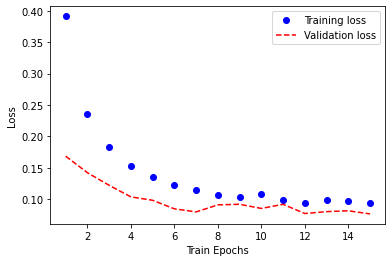

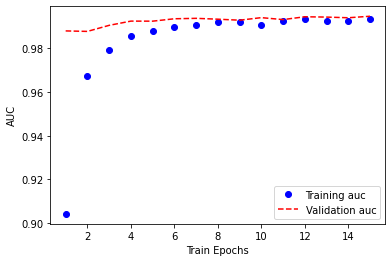

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

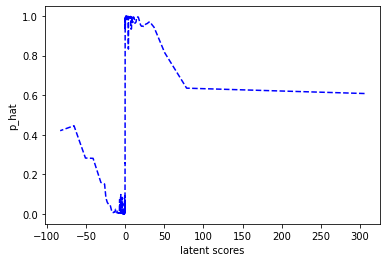

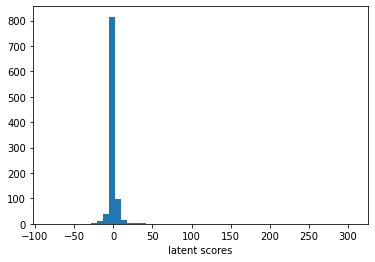

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

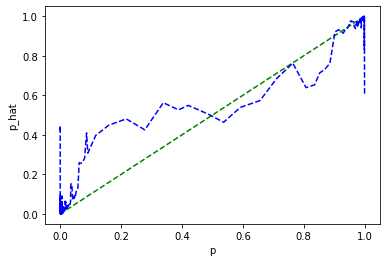

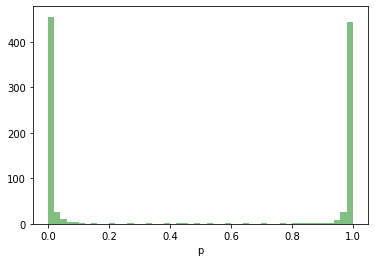

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

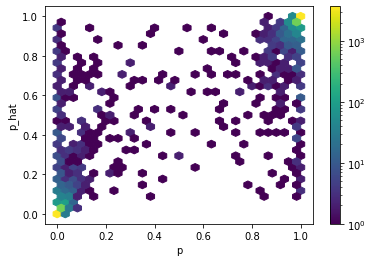

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

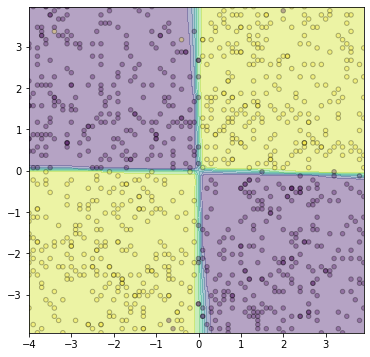

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.0084,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.07466189563274384, 'epoch': 15},
 'best_auc': {'auc': 0.9944226145744324, 'epoch': 16},
 'best_accuracy': {'accuracy': 0.9768499732017517, 'epoch': 15},
 'model': <keras.engine.sequential.Sequential at 0x7fa8a4125310>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.15360209345817566, 'epoch': 394},
  'best_auc': {'auc': 0.9912859201431274, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9627500176429749, 'epoch': 393}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.13573628664016724, 'epoch': 394},
  'best_auc': {'auc': 0.992440402507782, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.968999981880188, 'epoch': 393}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11104618012905121, 'epoch': 394},
  'best_auc': {'auc': 0.9931926727294922, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.9736499786376953, 'epoch': 393}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.1324302703142166, 'epoch': 828},
  'best_auc': {'auc': 0.99300616979599, 'epoch': 827},
  '

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25